# Frameworks

In [24]:
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import signal
from IPython.display import display, Markdown

# Leitura dos Dados Brutos

In [2]:
path_date = './DADOS/Dados eficiência da Usina Petrolina.xlsx'
df_full = pd.read_excel(path_date, usecols=['Time', 'Potência AC total (kW)', 'POA (W/m²)'])

In [3]:
df_full.head()

,Time,Potência AC total (kW),POA (W/m²)
0,2019-01-01 05:56:00,0.0,21.43
1,2019-01-01 05:57:00,0.0,23.98
2,2019-01-01 05:58:00,0.0,26.67
3,2019-01-01 05:59:00,0.0,30.27
4,2019-01-01 06:00:00,0.0,34.88


In [4]:
df_full.rename(columns={'Potência AC total (kW)':'P', 'POA (W/m²)':'G'}, inplace=True)

In [5]:
df_full.head()

,Time,P,G
0,2019-01-01 05:56:00,0.0,21.43
1,2019-01-01 05:57:00,0.0,23.98
2,2019-01-01 05:58:00,0.0,26.67
3,2019-01-01 05:59:00,0.0,30.27
4,2019-01-01 06:00:00,0.0,34.88


# Transformando o `DataFrame` em Série Teporal

In [6]:
df = df_full.copy()
df = df.set_index('Time')
df = df.sort_index(ascending=True)
df.head()

,P,G
Time,,
2019-01-01 05:56:00,0.0,21.43
2019-01-01 05:57:00,0.0,23.98
2019-01-01 05:58:00,0.0,26.67
2019-01-01 05:59:00,0.0,30.27
2019-01-01 06:00:00,0.0,34.88


# Análise Espectral de Potência

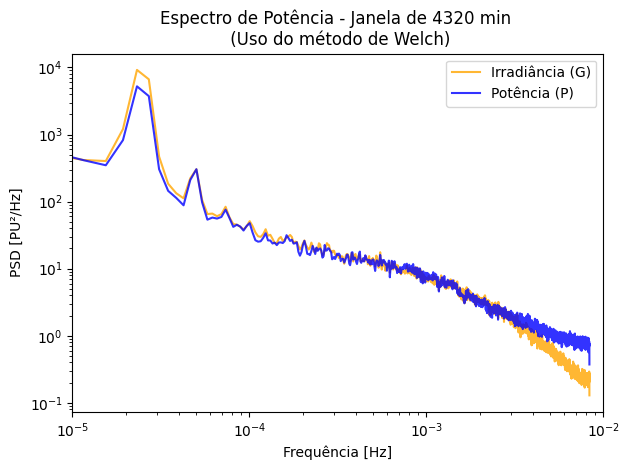

In [7]:
g_pu = (df['G'] / 1000).to_numpy()  
p_pu = (df['P'] / 2500).to_numpy()  

# Método de Welch
fs = 1/60
win_size = 4320 # 3 dias
win = signal.windows.hann(win_size)
noverlap = win_size/2
nfft = win_size # Número de pontos para a Transformada Rápida de Fourier

f_g, Sgg = signal.csd(g_pu, g_pu, fs, window = win, noverlap = noverlap, nfft = nfft, scaling = 'density')
f_p, Spp = signal.csd(p_pu, p_pu, fs, window = win, noverlap = noverlap, nfft = nfft, scaling = 'density') 

plt.loglog(f_g, Sgg, label='Irradiância (G)', alpha=0.8, color = 'orange')
plt.loglog(f_p, Spp, label='Potência (P)', alpha=0.8, color = 'blue')
plt.xlabel('Frequência [Hz]')
plt.ylabel('PSD [PU²/Hz]')
plt.title('Espectro de Potência - Janela de 4320 min \n (Uso do método de Welch)')
plt.xlim(1e-5, 1e-2)
plt.legend()
plt.tight_layout()
plt.savefig('./GRAFICOS/DADO_ORIGINAL_Espectro_de_Potência.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [8]:
dados = {
    'Frequência (Eixo x)': f_g,
    'Espectro de Irradiância (Eixo y)': Sgg,
    'Espectro de Potência (Eixo y)': Spp
}
pd.DataFrame(dados).to_excel('./DADOS/Dados_Do_Espectro_Para_Plotar_Com_Excel.xlsx')

![Discrepância do Espectro PSD](GRAFICOS\tabela_discrepancia_do_grafico_de_espectro.png)

## Incoerências Observadas (Problemas de Dados)

**O gráfico apresentou desvios críticos do esperado, rastreados até problemas de amostragem e qualidade dos dados:**

1) **Inversão do Efeito de Suavização (Alta Frequência):**

 * Ocorrência: A curva da Potência (P, azul) ficou acima da Irradiância (G, laranja) nas altas frequências.

 * Significado Incoerente: Isso sugere que a planta está, erroneamente, amplificando as flutuações rápidas (em vez de filtrá-las).

 * Causa Provável: A presença de dados zerados na potência ($P=0$) durante o dia com irradiância não nula ($G>0$). Tais eventos (como desligamento ou limitação) criam descontinuidades abruptas na série temporal. No domínio da frequência, essas descontinuidades se manifestam como ruído de alta frequência com alta energia, mascarando o efeito de suavização e elevando artificialmente o PSD de Potência.

2) **Ausência de Picos de Frequência Diária (Baixa Frequência)**

 * Ocorrência: Os picos nítidos de 24 horas (e 12 horas) em $f \approx 1.15 \times 10^{-5}$ Hz não são evidentes.

 * Causa Provável: O sensor foi desligado à noite (dados de 5:30h às 18h). O Método de Welch exige um sinal contínuo e a interrupção/truncamento noturno distorce a periodicidade de 24 horas, "espalhando" a energia do pico fundamental.

# Diante das incoerências, inicia-se a análise dos dados em busca de falhas na medição

# Verificando se há 525.600 Amostras _(Qtd. de Minutos em Um Ano)_

In [9]:
texto1 = 'Amostras Em Um Ano: ..................'
tamnaho_do_df = len(df.index)
print(f'{texto1} {tamnaho_do_df}')

texto2 = 'Qtd. de Minutos em Um Ano: ...........'
minutos_em_um_ano = 365 * 24 * 60
print(f'{texto2}', minutos_em_um_ano)

texto3 = 'Percentual de Minutos Não coletadas: .'
percentual = ((minutos_em_um_ano - len(df.index))/minutos_em_um_ano)*100
print(f'{texto3} {percentual:.2f} {'%'}')

texto4 = 'Qtd. de Dados Não Coletados:..........'
print(f'{texto4}', minutos_em_um_ano - len(df.index))

Amostras Em Um Ano: .................. 244154
Qtd. de Minutos em Um Ano: ........... 525600
Percentual de Minutos Não coletadas: . 53.55 %
Qtd. de Dados Não Coletados:.......... 281446


# Identificando e Quantificando os "Buracos" nos Dados do Sensor

In [10]:
# Calcula a diferença de tempo entre uma linha e a anterior
time_diffs = df.index.to_series().diff()
# Filtra onde a diferença é maior que 1 minuto
gaps = time_diffs[time_diffs > pd.Timedelta('1min')]
print(f"Total de 'gaps' na amostragem: ... {len(gaps)}")
gaps.head()

Total de 'gaps' na amostragem: ... 491


Time
2019-01-02 05:48:00   0 days 12:17:00
2019-01-02 17:26:00   0 days 00:03:00
2019-01-03 05:54:00   0 days 12:27:00
2019-01-03 17:19:00   0 days 00:04:00
2019-01-04 05:56:00   0 days 12:36:00
Name: Time, dtype: timedelta64[ns]

# Verificando se há _NaN_

* A tecnica `df.isna().sum()` retornou **False** para todos,
isso implica que há saltos temporais no registro da base.
Alguém poderia achar que o sensor fez o registro do tempo na coluna **Time**,
mas o valor da coluna da irradiancia e da potencia ficou com _NaN_
O teste mostra que não é o caso.

In [11]:
df.isna().sum()

P    0
G    0
dtype: int64

# SubPlot Com Gráfico de dispersão Para verificar como os registros de Potência e Irradiância ocorrem ao longo de _24h_

A análise do gráfico confirma tudo que já vinhamos notando:

* Dados NÃO **EXISTENTES** para periodos Noturnos (Antes das 5h e depois das 18h);
* Ideitifica-se valores **ZERADOS** para potência em horário de sol pleno. 

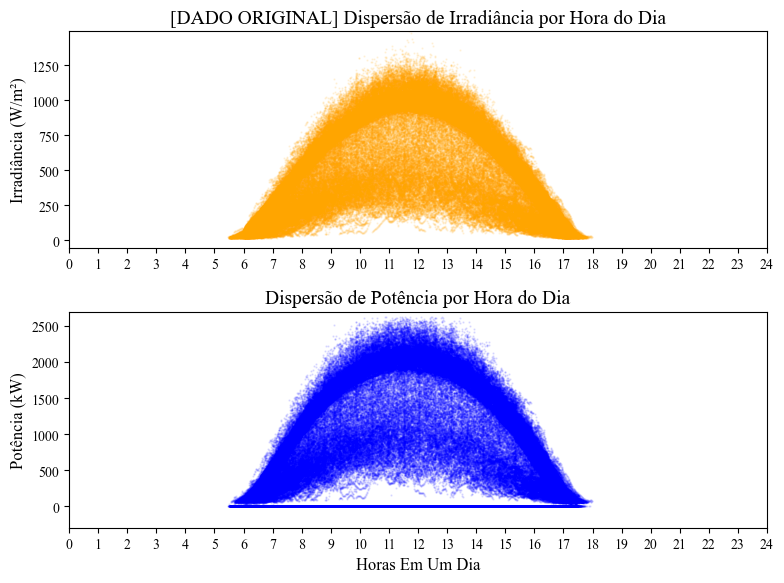

In [12]:
plt.rcParams.update({
    'font.family': 'serif',          # Define que a família será serifada
    'font.serif': ['Times New Roman'], # Especifica Times New Roman
    'font.size': 12,                 # Tamanho base
    'axes.labelsize': 12,            # Tamanho dos eixos
    'axes.titlesize': 14,            # Tamanho do título
    'xtick.labelsize': 10,           # Tamanho dos números em X
    'ytick.labelsize': 10,           # Tamanho dos números em Y
    'legend.fontsize': 10,           # Tamanho da legenda
    'figure.figsize': (8, 6),        # Tamanho da figura
    'mathtext.fontset': 'stix'       # Deixa as fórmulas matemáticas bonitas (estilo LaTeX)
})
# Criar coluna de hora decimal para o eixo X (ex: 14:30 = 14.5)
df['HoraDecimal'] = df.index.hour + df.index.minute / 60
# Plot da Irradiância
plt.subplot(2, 1, 1)
plt.scatter(df['HoraDecimal'], df['G'], s=0.5, alpha=0.1, color='orange')
plt.title('[DADO ORIGINAL] Dispersão de Irradiância por Hora do Dia')
plt.ylabel('Irradiância (W/m²)')
plt.xlim(0, 24)
plt.ylim(-50, 1492.9)
#plt.grid(True, alpha=0.1)
plt.xticks(list(range(0, 25)))
# Plot da Potência
plt.subplot(2, 1, 2)
plt.scatter(df['HoraDecimal'], df['P'], s=0.5, alpha=0.1, color='blue')
plt.title('Dispersão de Potência por Hora do Dia')
plt.xlabel('Horas Em Um Dia')
plt.ylabel('Potência (kW)')
plt.xlim(0, 24)
plt.ylim(-300, 2700) 
#plt.grid(True, alpha=0.1)
plt.xticks(list(range(0, 25)))
plt.tight_layout()
plt.savefig('./GRAFICOS/DADO_ORIGINAL_dispersão_da_irradiância_e_potencia_por_hora_do_dia.png', format='png', dpi=600, bbox_inches='tight')

# Uma Análise Mais Profunda dos _`Gaps`_ Focada nos Dados Faltantes e Inconsistentes **No Período Diurno**

* Dados, mesmo que ausentes, se no período noturno, **são zeros por definição**.
A maior preocupação são os dados inconsistentes e ausentes nos períodos de sol, pois a inserção de dados que não sigam uma distribuição de probabilidade coerente com o fenômeno físico, necessariamente, adicionará viés aos valores de irradiação e potência, o que pode subestimar ou sobrestimar as flutuações, incorrendo em uma análise espectral errada no futuro.

In [13]:
# Apenas período diúrno
hours = df.index.hour
mask_night = (hours < 5) | (hours >= 19)
mask_day = ~mask_night
df_day = df.loc[mask_day]
# Calcula a diferença de tempo entre uma linha e a anterior
time_day_diffs = df_day.index.to_series().diff()
# Filtra onde a diferença é maior que 1 minuto e menor do que 10h (600min)
gaps_day = time_day_diffs[(time_day_diffs > pd.Timedelta('1min')) & (time_day_diffs < pd.Timedelta('640min'))]
print(f"Total de 'gaps_day' na amostragem: ... {len(gaps_day)}")
print('\n', 'Máximo:',gaps_day.max(),'\n', 'Mínimo:',gaps_day.min())

Total de 'gaps_day' na amostragem: ... 128

 Máximo: 0 days 03:41:00 
 Mínimo: 0 days 00:02:00


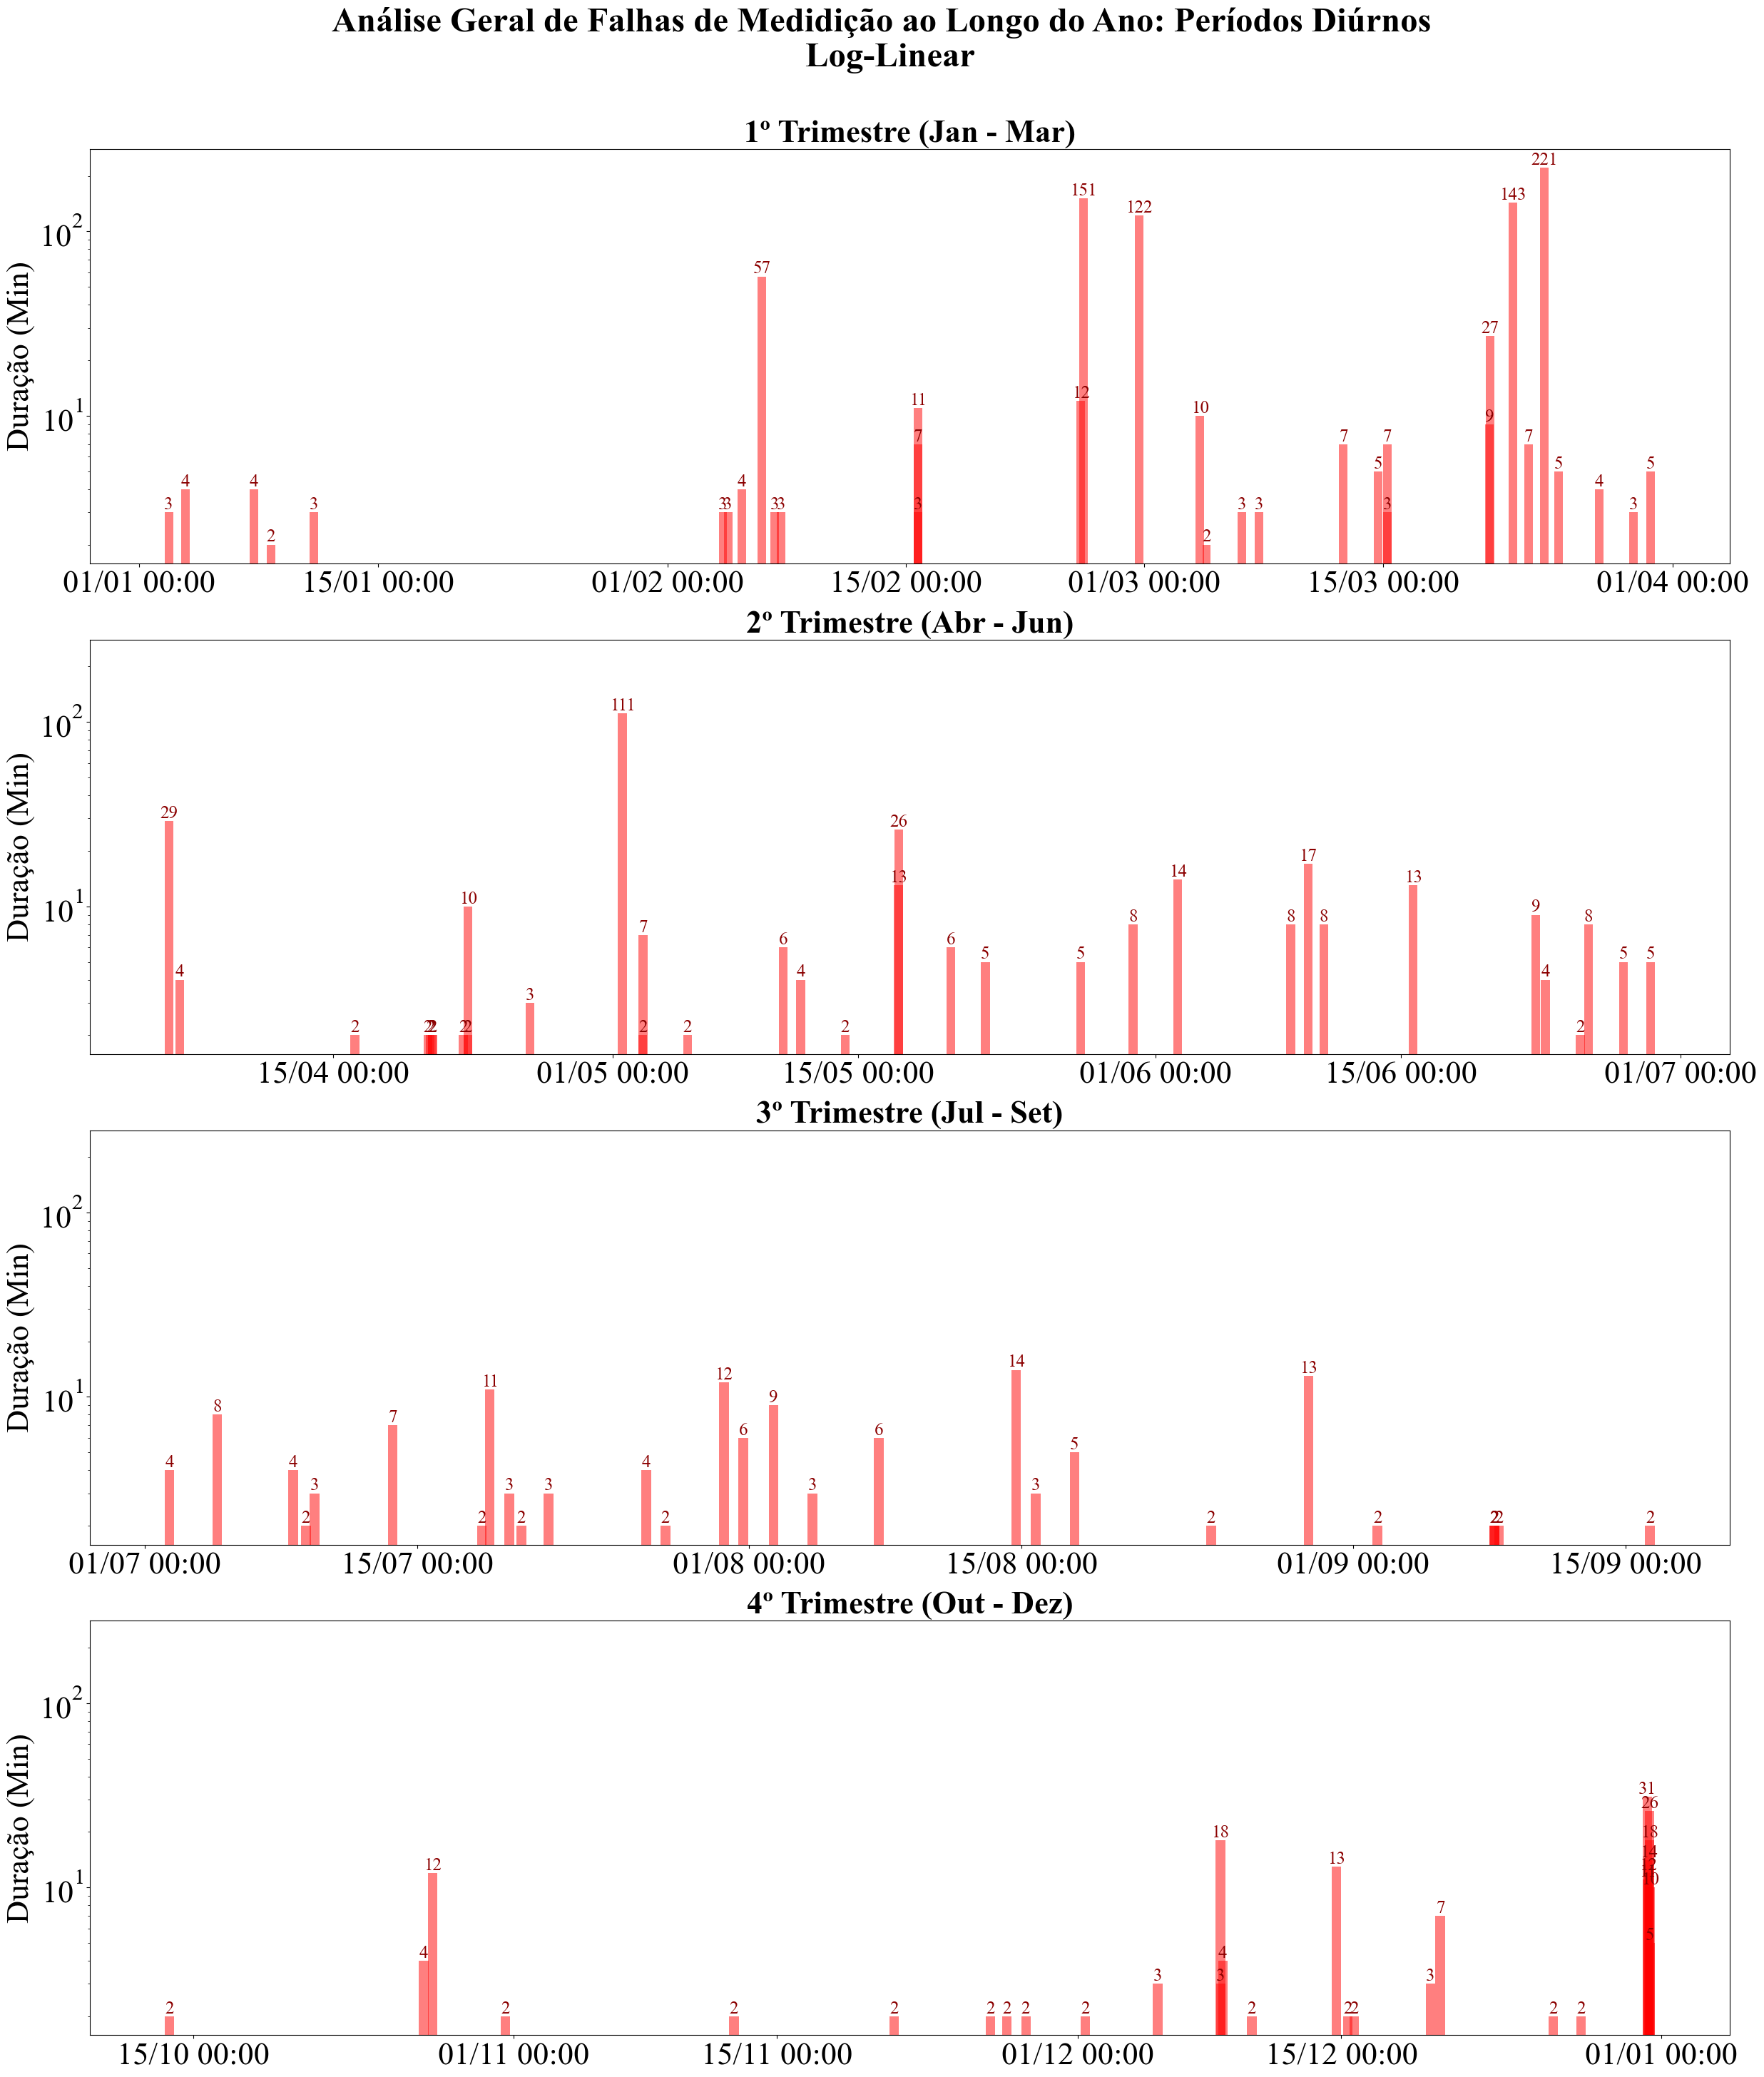

In [14]:
gaps_q1 = gaps_day[gaps_day.index.month <= 3]
gaps_q2 = gaps_day[(gaps_day.index.month > 3) & (gaps_day.index.month <= 6)]
gaps_q3 = gaps_day[(gaps_day.index.month > 6) & (gaps_day.index.month <= 9)]
gaps_q4 = gaps_day[gaps_day.index.month > 9]
fontsize_= 32
if len(gaps_day) > 0:
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 30), sharey=True)
    fig.suptitle('Análise Geral de Falhas de Medidição ao Longo do Ano: Períodos Diúrnos \n Log-Linear', fontsize=35, fontweight='bold', y=0.97)
    def plotar_periodo(ax, dados, titulo):
        if len(dados) == 0:
            ax.text(0.5, 0.5, "Sem falhas registradas neste trimestre", 
                    ha='center', va='center', transform=ax.transAxes, fontsize=fontsize_, color='gray')
            ax.set_title(titulo, fontsize=fontsize_, fontweight='bold')
            ax.grid(True, linestyle='--', alpha=0.3)
            return
        minutos = dados.dt.total_seconds() / 60
        ax.bar(dados.index, minutos, width=0.5, color='red', alpha=0.5)
        ax.set_yscale('log')
        ax.set_title(titulo, fontsize=fontsize_, fontweight='bold')
        ax.set_ylabel('Duração (Min)', fontsize=fontsize_)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
        #ax.grid(True, linestyle='--', alpha=0.5)
        for date, duration in zip(dados.index, minutos):
            ax.annotate(f'{int(duration)}', 
                        xy=(date, duration), 
                        xytext=(0, 3), textcoords='offset points', 
                        ha='center', fontsize=18, color='darkred')
    configuracoes = [
        (axes[0], gaps_q1, '1º Trimestre (Jan - Mar)'),
        (axes[1], gaps_q2, '2º Trimestre (Abr - Jun)'),
        (axes[2], gaps_q3, '3º Trimestre (Jul - Set)'),
        (axes[3], gaps_q4, '4º Trimestre (Out - Dez)')]
    for ax, dados, titulo in configuracoes:
        plotar_periodo(ax, dados, titulo)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=fontsize_)
        plt.setp(ax.yaxis.get_majorticklabels(), fontsize=fontsize_) 
    # O parametro rect=[0, 0, 1, 0.96] diz para o layout usar apenas os 96% de baixo da figura,
    # deixando os 4% do topo livres para o suptitle não ser atropelado.
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    #plt.savefig('./GRAFICOS/Analise Geral de Falhas de Medidição ao Longo do Ano Para Períodos Diúrnos.png', format='png', dpi=600, bbox_inches='tight')
    plt.savefig('./GRAFICOS/Analise Geral de Falhas de Medidição ao Longo do Ano Para Períodos Diúrnos.pdf', format='pdf', bbox_inches='tight')
    plt.show()
else:
    print("Nenhum gap encontrado.")

In [15]:
# RECONSTRUÇÃO DA LINHA DO TEMPO
start = df.index.min().floor('D')
end = df.index.max().ceil('D')
full_index = pd.date_range(start, end, freq='1min', inclusive='left')
# Reindexa: Cria as linhas que faltavam (buracos) e preenche com NaN
df_new = df.reindex(full_index)
df_new

,P,G,HoraDecimal
2019-01-01 00:00:00,NaN,NaN,NaN
2019-01-01 00:01:00,NaN,NaN,NaN
2019-01-01 00:02:00,NaN,NaN,NaN
2019-01-01 00:03:00,NaN,NaN,NaN
2019-01-01 00:04:00,NaN,NaN,NaN
...,...,...,...
2019-12-31 23:55:00,NaN,NaN,NaN
2019-12-31 23:56:00,NaN,NaN,NaN
2019-12-31 23:57:00,NaN,NaN,NaN
2019-12-31 23:58:00,NaN,NaN,NaN


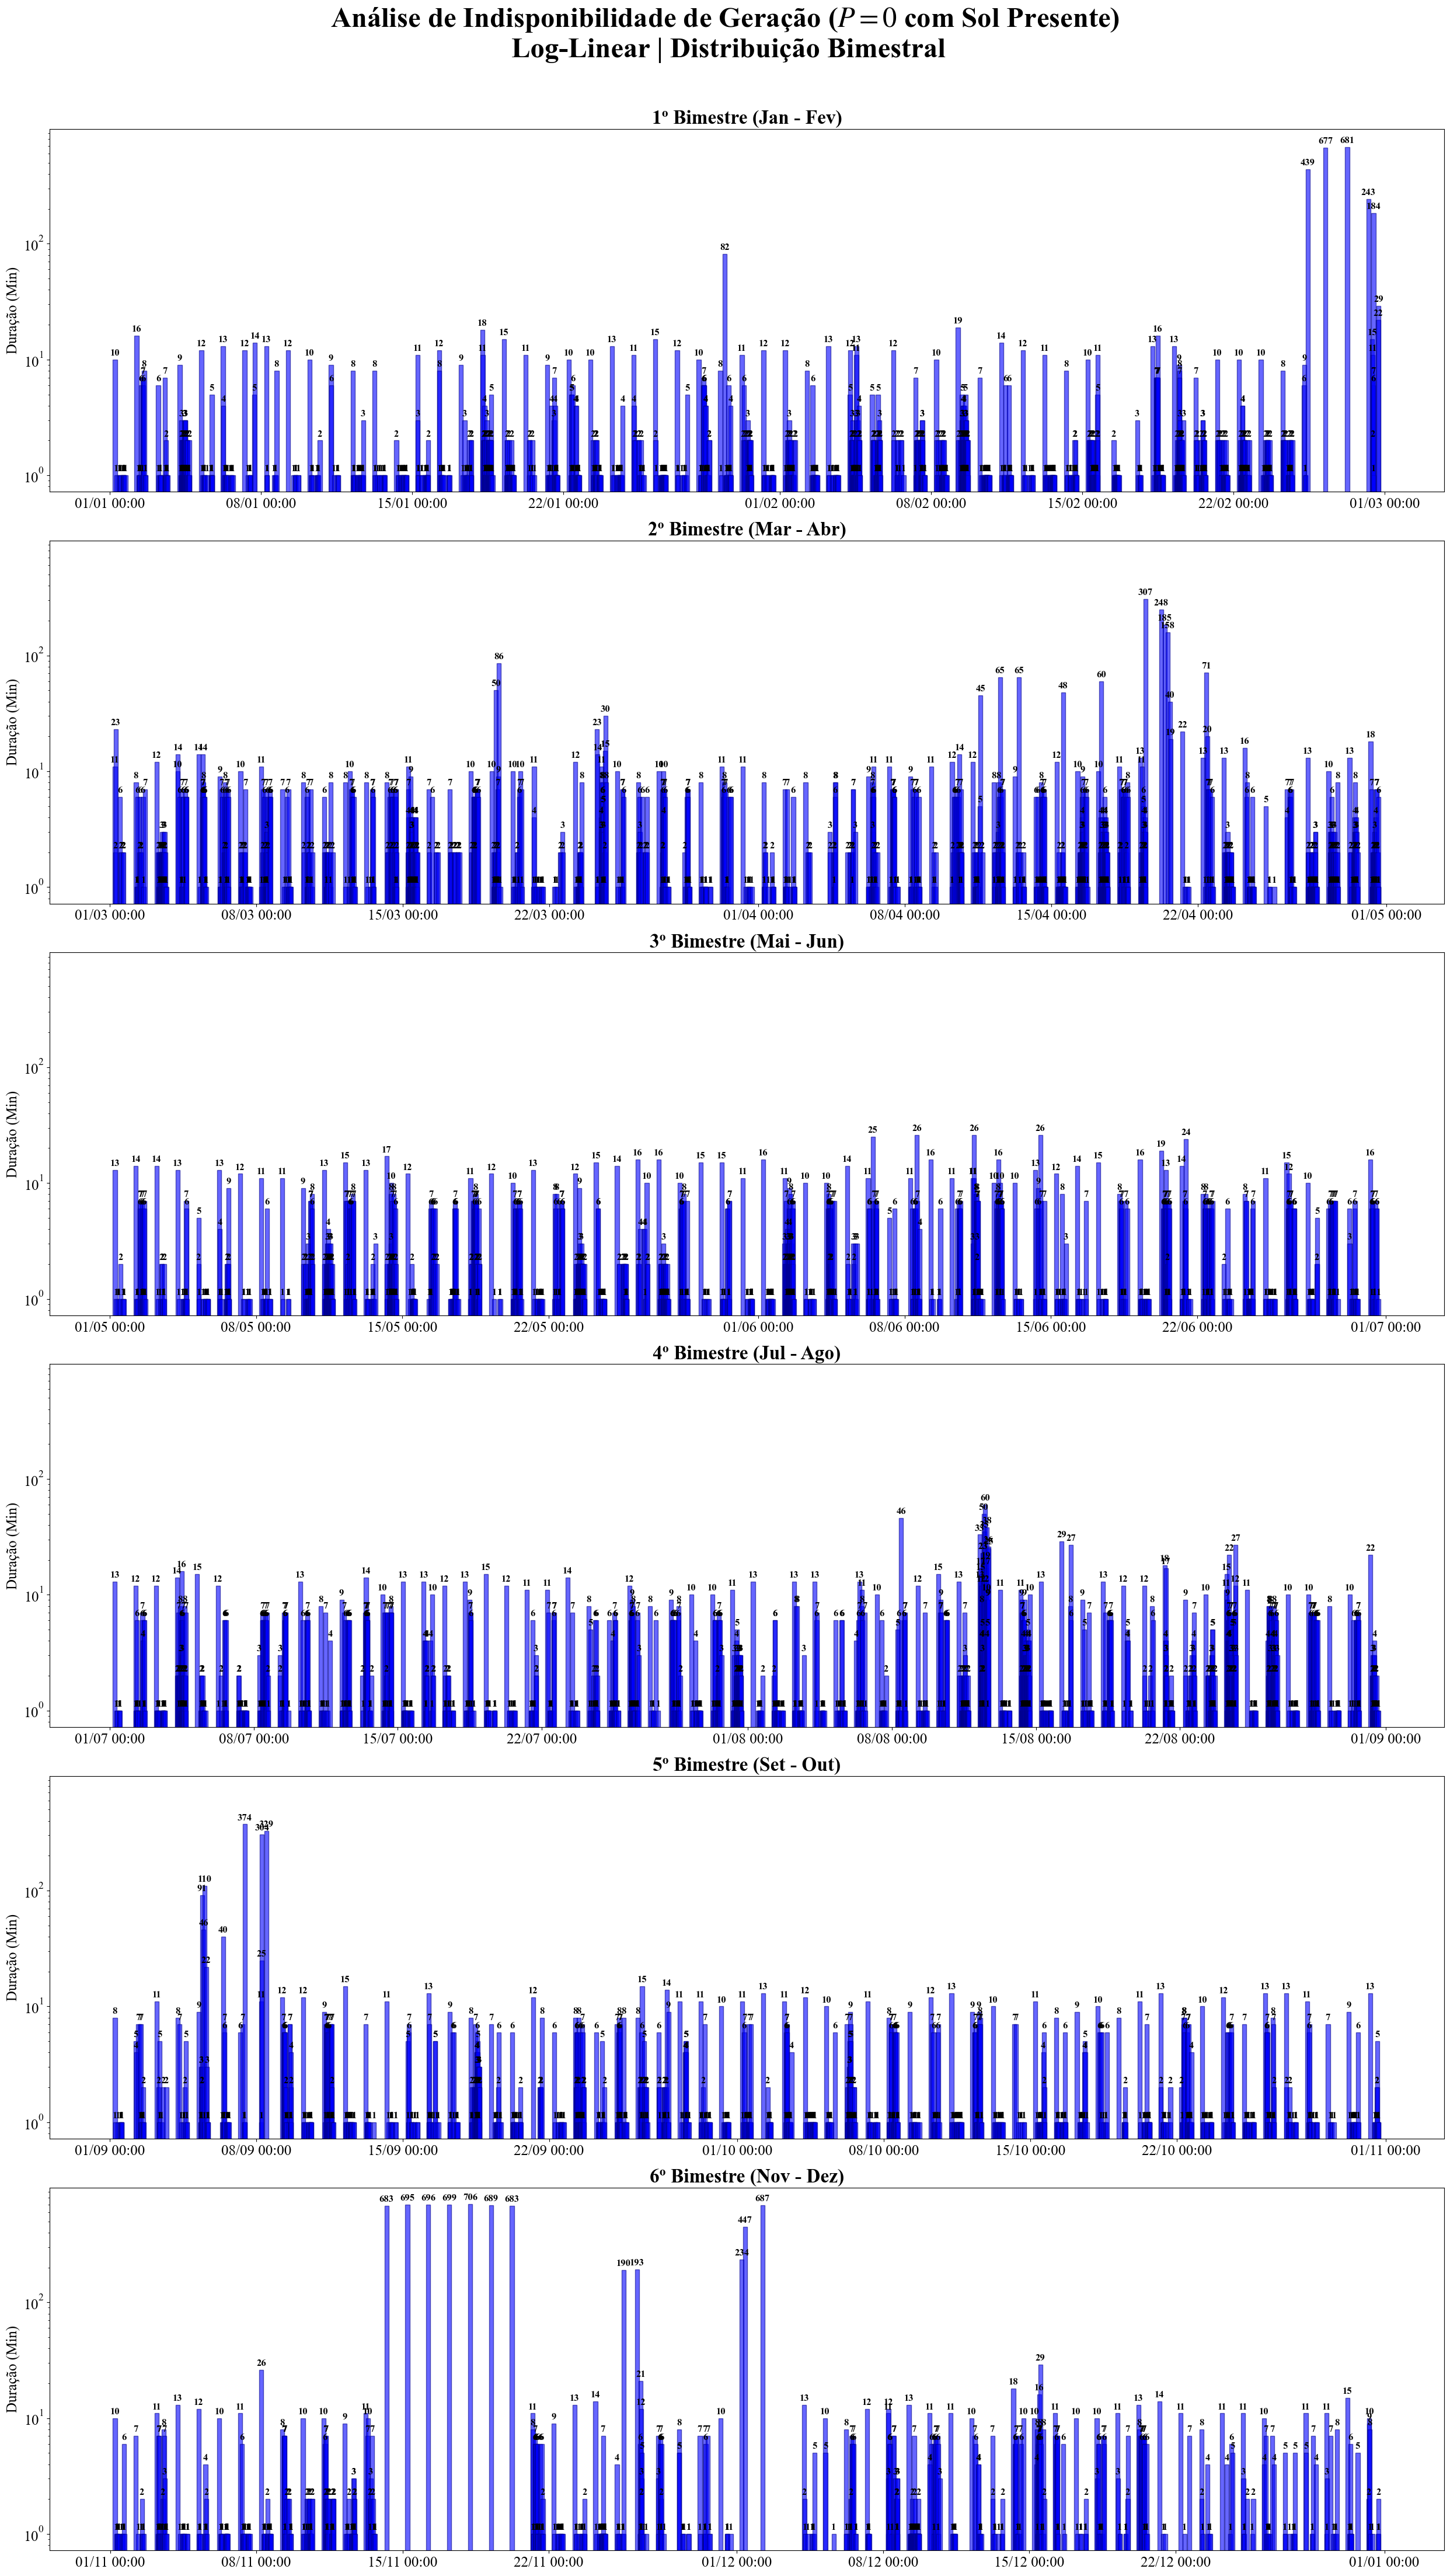

In [16]:
df_new = df_new.sort_index()
mask_zero_power = (df_new['P'] <= 0) & (df_new['G'] > 0)
blocos_series = (mask_zero_power != mask_zero_power.shift()).cumsum()
df_falhas = df_new[mask_zero_power].copy()
df_falhas['id_evento'] = blocos_series[mask_zero_power]
eventos_zero = []
if not df_falhas.empty:
    for id_bloco, dados_bloco in df_falhas.groupby('id_evento'):
        inicio = dados_bloco.index[0]
        fim = dados_bloco.index[-1]
        delta_tempo_min = (fim - inicio).total_seconds() / 60
        duracao_real = delta_tempo_min + 1
        eventos_zero.append({
            'Data': inicio, 
            'Duracao': duracao_real,
            'Fim': fim # Opcional: útil para auditoria
        })
if len(eventos_zero) > 0:
    df_eventos = pd.DataFrame(eventos_zero).set_index('Data')
    gaps_day = df_eventos['Duracao']
    gaps_b1 = gaps_day[gaps_day.index.month.isin([1, 2])]
    gaps_b2 = gaps_day[gaps_day.index.month.isin([3, 4])]
    gaps_b3 = gaps_day[gaps_day.index.month.isin([5, 6])]
    gaps_b4 = gaps_day[gaps_day.index.month.isin([7, 8])]
    gaps_b5 = gaps_day[gaps_day.index.month.isin([9, 10])]
    gaps_b6 = gaps_day[gaps_day.index.month.isin([11, 12])]
    fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(25, 45), sharey=True)
    fig.suptitle('Análise de Indisponibilidade de Geração ($P=0$ com Sol Presente)\n Log-Linear | Distribuição Bimestral', 
                 fontsize=35, fontweight='bold', y=0.98)
    configuracoes = [ 
        (axes[0], gaps_b1, '1º Bimestre (Jan - Fev)'),
        (axes[1], gaps_b2, '2º Bimestre (Mar - Abr)'),
        (axes[2], gaps_b3, '3º Bimestre (Mai - Jun)'),
        (axes[3], gaps_b4, '4º Bimestre (Jul - Ago)'),
        (axes[4], gaps_b5, '5º Bimestre (Set - Out)'),
        (axes[5], gaps_b6, '6º Bimestre (Nov - Dez)')]
    for ax, dados, titulo in configuracoes:
        if len(dados) == 0:
            ax.text(0.5, 0.5, "Sem registros neste bimestre", 
                    ha='center', va='center', transform=ax.transAxes, fontsize=18, color='gray')
            ax.set_title(titulo, fontsize=24, fontweight='bold')
            # Esconde ticks se vazio para ficar mais limpo
            ax.set_xticks([]) 
        else:
            ax.bar(dados.index, dados.values, width=0.2, color='blue', edgecolor='darkblue', alpha=0.6)
            ax.set_yscale('log')
            ax.set_title(titulo, fontsize=24, fontweight='bold')
            ax.set_ylabel('Duração (Min)', fontsize=18)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
            ax.tick_params(axis='x', labelsize=18, rotation=0)
            ax.tick_params(axis='y', labelsize=18)
            for date, duration in zip(dados.index, dados.values):
                ax.annotate(f'{int(duration)}', 
                            xy=(date, duration), 
                            xytext=(0, 5), textcoords='offset points', 
                            ha='center', fontsize=12, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    # plt.savefig('./GRAFICOS/Analise_Bimestral_Potencia_Zero.pdf', format='pdf', bbox_inches='tight')
    plt.show()

else:
    print("Nenhum evento de Potência Zerada com Sol foi encontrado.")

In [17]:
mask_dia = (df_new.index.hour > 5) & (df_new.index.hour < 19)
dias = df_new[mask_dia]
total_amostras = dias.shape[0]
falha_na_potencia = dias[(dias['P'] == 0) & (dias['G'] > 0)].shape[0]
display(Markdown(f'**Total De Amostras de 1 min. (05h às 19h):** -------------  {total_amostras}'))
display(Markdown(f'**Total De Potência $P = 0$ com Irradiação $G > 0$:** ------- {falha_na_potencia}'))

display(Markdown(f'**Porcentagem de Potencias Erradas no ano:** ------------- {falha_na_potencia/ total_amostras*100:.2f} %'))

dias[(dias['P']==0) & (dias['G']>0)]

**Total De Amostras de 1 min. (05h às 19h):** -------------  284700

**Total De Potência $P = 0$ com Irradiação $G > 0$:** ------- 28043

**Porcentagem de Potencias Erradas no ano:** ------------- 9.85 %

,P,G,HoraDecimal
2019-01-01 06:00:00,0.0,34.880000,6.000000
2019-01-01 06:01:00,0.0,39.030000,6.016667
2019-01-01 06:02:00,0.0,42.730000,6.033333
2019-01-01 06:03:00,0.0,46.610000,6.050000
2019-01-01 06:04:00,0.0,49.250000,6.066667
...,...,...,...
2019-12-31 10:28:00,0.0,172.200000,10.466667
2019-12-31 16:45:00,0.0,98.700000,16.750000
2019-12-31 17:23:00,0.0,34.928571,17.383333
2019-12-31 17:28:00,0.0,26.630000,17.466667


# Considerando a Usina Como Um Filtro _Low-Pass_ Para correção de Falhas curtas e cutissimas `Igual ou Inferior a 5 Min.` 

Marcos et al. mostra que:


$$ \large H(s) = \frac{P(s)}{G(s)} = \frac{K}{\tau s + 1}$$

Onde:

* $P(s)$ é a saída (Potência).

* $G(s)$ é a entrada (Irradiação).

* $\tau$ é a constante de tempo baseada na área da usina em hectares ($\large \frac{\sqrt{S}}{2\pi \cdot 0.021}$).

## Manipulando $H(s)$ para aplicar a inversa de Laplace:

$$\large P(s) \cdot (\tau s + 1) = K \cdot G(s)$$

$$\large P(s) \cdot \tau s + P(s) = K \cdot G(s)$$

Aplicando ($\mathcal{L}^{-1}$), fica: 

$$\large h(t) = \mathcal{L}^{-1} \{H(s)\}$$

Então:

$$\large \tau \frac{dP(t)}{dt} + P(t) = K \cdot G(t)$$

Discretizando a derivada temporal via método de Euler (Retanglar Para frente - Backfoward):

$$\large \frac{dP(t)}{dt} \approx \frac{P[t] - P[t-1]}{\Delta t}$$

Onde:

* $\Delta t$ é o seu tempo de amostragem

Substituindo fica:

$$\large \tau \left( \frac{P[t] - P[t-1]}{\Delta t} \right) + P[t] = K \cdot G[t]$$

Isolando $\large P[t]$

$$\large \tau (P[t] - P[t-1]) + P[t] \Delta t = K G[t] \Delta t$$


$$\large P[t](\tau + \Delta t) = K G[t] \Delta t + \tau P[t-1]$$


$$\large P[t] = \left( \frac{\Delta t}{\tau + \Delta t} \right) K G[t] + \left( \frac{\tau}{\tau + \Delta t} \right) P[t-1]$$

Para simplificar a expressão, podems assumir que:

$$\large \alpha = \frac{\Delta t}{\tau + \Delta t}$$

$$\large 1 - \alpha = 1 - \left( \frac{\Delta t}{\tau + \Delta t} \right)$$

$$\large 1 - \alpha = \frac{\tau + \Delta t - \Delta t}{\tau + \Delta t}$$

$$\large 1 - \alpha = \frac{\tau}{\tau + \Delta t}$$

Então, substituindo na equação fica:

$$\large P[t] = \alpha \cdot (K \cdot G[t]) + (1 - \alpha) \cdot P[t-1]$$


## Anáise:

$$P[t] = \underbrace{\alpha}_{\text{Peso do Novo}} \cdot (\text{Entrada Atual}) + \underbrace{(1 - \alpha)}_{\text{Peso do Velho}} \cdot (\text{Histórico})$$

* $\large \alpha$: representa a contribuição do dado novo para a saída. 

* $(\large 1 - \alpha)$: Representa a contribuição da inércia (do estado anterior do sistema). Como a soma dos pesos é sempre $1$ ($\alpha + (1-\alpha) = 1$), isso garante que o filtro nunca vai criar ou destruir energia artificialmente, apenas balancear.

## Calculando $\alpha$:

* Área da Usina $(\large S)$: $\large 1,48$ hectares (calculado a partir dos 7.600 módulos).
* Tempo de Amostragem ($\large \Delta t$ ou $T_s$): $60$ segundos.

**1. Cálculo da Frequência de Corte ($\large f_c$)**

A equação empírica nos dá $\large f_c$ em Hz:

$$\large f_c = 0.021 \cdot S^{-0.5}$$

$$\large f_c = \frac{0,021}{\sqrt{S}}$$$$f_c = \frac{0,021}{\sqrt{1,48}}$$$$f_c \approx \frac{0,021}{1,21655}$$$$f_c \approx 0,01726 \, \text{Hz}$$

2. Determianando a Constante de Tempo $\large \tau$

$$\large \tau \triangleq \frac{1}{2\pi f_c}$$

A constante de tempo tau ($\tau$) é o inverso da frequência angular ($2\pi f_c$):

$$\tau = \frac{1}{2 \cdot 3,14 \cdot 0,01726}$$

$$\tau = \frac{1}{0,1084}$$$$\tau \approx 9,225 \, \text{segundos}$$

Isso significa que a usina leva cerca de 9,2 segundos para "sentir" plenamente o efeito de uma variação brusca de irradiância devido à sua inércia espacial.

Portanto $\alpha$ fica:

$$\large\alpha = \frac{\Delta t}{\tau + \Delta t}$$$$\large\alpha = \frac{60}{9,225 + 60}$$$$\large\alpha = \frac{60}{69,225}$$$$\large\mathbf{\alpha \approx 0,8667}$$

Isso significa que, a cada minuto, o valor da potência é composto por:

* 86,6% da irradiação que está chegando agora ($\alpha$).

* 13,4% da potência que já estava lá no minuto anterior ($1 - \alpha$).

Isso faz sentido físico: como a amostragem é lenta (1 min) e a usina é rápida (~9s), o "novo dado" tem muito mais peso que a "memória" do sistema.

In [160]:
def corrigir_falhas_curtas(df, alpha, limite_minutos=5, janela_vizinhos=10):
    """
    df: DataFrame com índice datetime, colunas 'P' e 'G'.
    alpha: Coeficiente do filtro low-pass.
    limite_minutos: Duração máxima da falha para aplicar correção.
    janela_vizinhos: Quantos minutos antes e depois olhar para calcular o K.
    """
    df_out = df.copy()
    if 'P_corrigida' not in df_out.columns:
        df_out['P_corrigida'] = df_out['P'].copy()
    # Identificar Falhas (P=0 e G>0)
    mask_falha = (df_out['P'] == 0) & (df_out['G'] > 0)
    # Criar IDs de blocos
    blocos = (mask_falha != mask_falha.shift()).cumsum()
    count_corrigidos = 0
    # Varrer os blocos de falha
    # Filtramos apenas os grupos onde mask_falha é True
    grupos_falha = df_out[mask_falha].groupby(blocos)
    for id_bloco, dados_bloco in grupos_falha:
        duracao = len(dados_bloco)
        if duracao <= limite_minutos:
            idx_inicio = dados_bloco.index[0]
            idx_fim = dados_bloco.index[-1]
            # Calcular Ganho Local (K)
            # 'janela_vizinhos' antes e depois
            pos_inicio = df_out.index.get_loc(idx_inicio)
            pos_fim = df_out.index.get_loc(idx_fim)
            inicio_viz = max(0, pos_inicio - janela_vizinhos)
            fim_viz = min(len(df_out), pos_fim + janela_vizinhos + 1)
            df_vizinhos = df_out.iloc[inicio_viz : fim_viz]
            # vizinhos que SÃO VÁLIDOS (P > 0 e G > 0) para calcular o K
            mask_validos = (df_vizinhos['P'] > 0) & (df_vizinhos['G'] > 0)
            vizinhos_bons = df_vizinhos[mask_validos]
            if len(vizinhos_bons) > 0:
                # K = Média de (P / G) no entorno
                K_local = (vizinhos_bons['P'] / vizinhos_bons['G']).mean()
            else:
                continue 
            # Aplicar a Fórmula Recursiva
            # Precisamos do valor anterior ao início da falha para começar a inércia
            # Se a falha começa no índice 0, assumimos P_anterior = K * G
            if pos_inicio > 0:
                p_anterior = df_out.iloc[pos_inicio - 1]['P_corrigida']
                # Se o anterior também estava zerado estimamos pelo K
                if p_anterior <= 0:
                     p_anterior = K_local * df_out.iloc[pos_inicio]['G']
            else:
                p_anterior = K_local * df_out.iloc[pos_inicio]['G']
            # Loop linha a linha DENTRO da falha para aplicar a recorrência
            for t in dados_bloco.index:
                g_atual = df_out.loc[t, 'G']
                p_novo = (alpha * (K_local * g_atual)) + ((1 - alpha) * p_anterior)
                # Atualiza o DataFrame e a variável de estado
                df_out.loc[t, 'P_corrigida'] = p_novo
                p_anterior = p_novo
            count_corrigidos += 1
    print(f"Processo concluído. {count_corrigidos} eventos de falha curta foram reconstruídos.")
    return df_out

In [161]:
df_new_test1 = corrigir_falhas_curtas(df_new, 
                                      alpha = 0.8667,
                                      limite_minutos=5,
                                      janela_vizinhos=10)

Processo concluído. 5229 eventos de falha curta foram reconstruídos.


<Axes: >

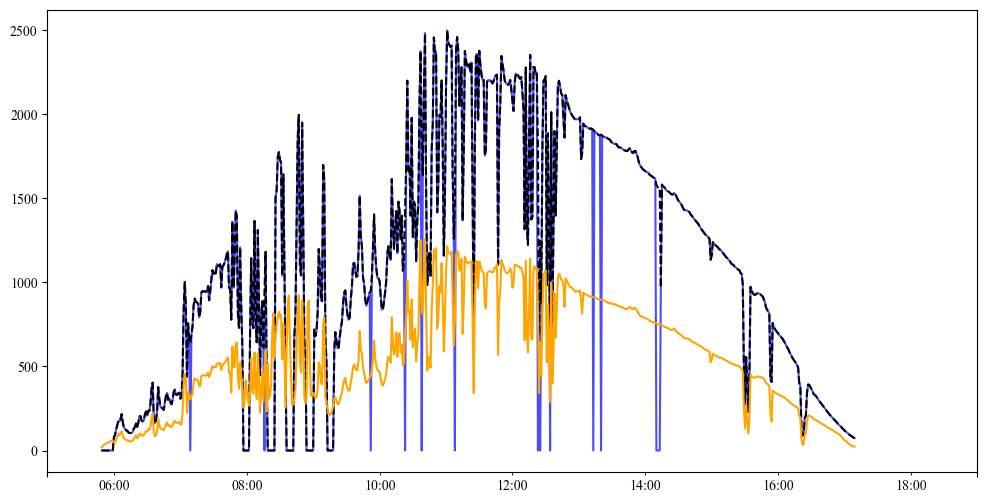

In [163]:
recorte = df_new_test1.loc['2019-10-03 05:00:00':'2019-10-03 19:00:00']
#titulo = f'Sobreposição da Potencia Original, Irradiação e Potencia Corrigida Para {inicio}'
fig, ax = plt.subplots(figsize=(12, 6))
recorte['P'].plot(ax = ax, color = 'blue', alpha = 0.7)
recorte['P_corrigida'].plot(ax = ax, style = '--', color = 'black')
recorte['G'].plot(ax = ax, color = 'orange')

#plt.savefig(f'./GRAFICOS/{titulo}.pdf', format='pdf', bbox_inches='tight')

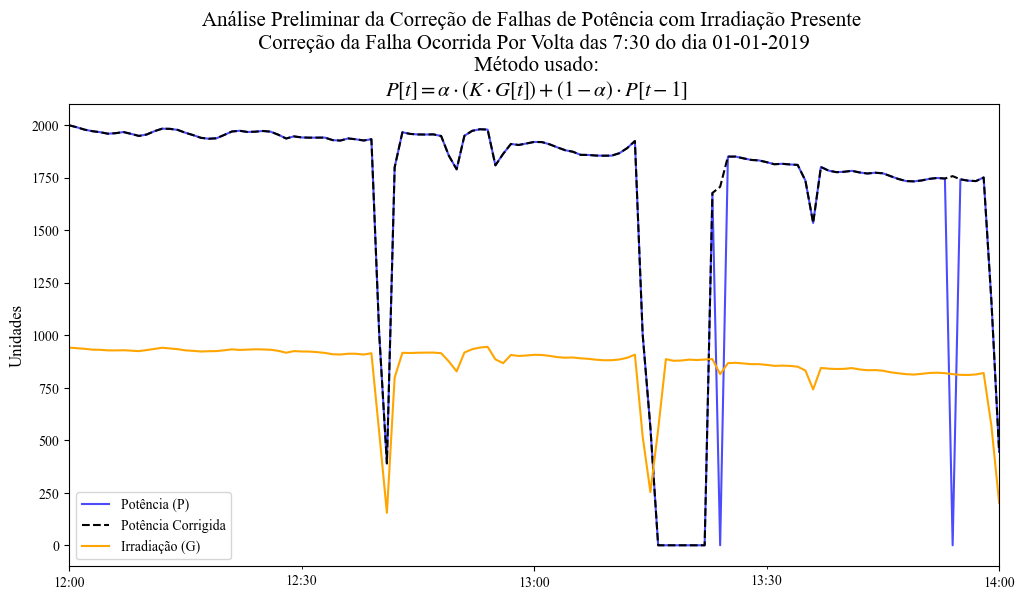

In [159]:
recorte = df_new_test1.loc['2019-01-03 12:0:00':'2019-01-03 14:00:00']
fig, ax = plt.subplots(figsize=(12, 6))
recorte['P'].plot(ax=ax, color='blue', label='Potência (P)', alpha = 0.7)
recorte['P_corrigida'].plot(ax=ax, color='black', label='Potência Corrigida', style = '--')
recorte['G'].plot(ax=ax, color='orange', label='Irradiação (G)')

titulo_texto = "Análise Preliminar da Correção de Falhas de Potência com Irradiação Presente \n Correção da Falha Ocorrida Por Volta das 7:30 do dia 01-01-2019 \n Método usado:\n"
titulo_formula = r"$\ P[t] = \alpha \cdot (K \cdot G[t]) + (1 - \alpha) \cdot P[t-1]$"
ax.set_title(titulo_texto + titulo_formula, fontsize=15)
ax.set_ylabel('Unidades')
ax.legend()
#plt.savefig('./GRAFICOS/Análise_Preliminar_da_Correção_de_Falhas_de_Potência_com_Irradiação_Presente.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plot do Gráfico de Flutuação de Irradiancia

In [ ]:
# CÁLCULO DAS FLUTUAÇÕES DE IRRADIANCIA
deltas = [1, 10] # Delta t = 1 min e Delta t = 10 min
cores = ['red', 'cyan'] # Cores iguais ao artigo para 60s e 600s
irradiacao_de_referencia = 1000
for delta_t, cor in zip(deltas, cores):
    # O método .diff do Pandas: .diff(periods=k) faz G(t) - G(t-k)
    # A fórmula do artigo: (Diferença / 1000) * 100
    fluctuation_G = (df_new['G'].diff(periods=delta_t) / irradiacao_de_referencia) * 100
    # Remover o NaN gerados pelo .diff
    fluctuation_G = fluctuation_G.dropna()
    # CRIAÇÃO DO HISTOGRAMA (Bins de 1%)
    # faixas de -120% a +120% com passo de 1%
    bins = np.arange(-120, 121, 1) 
    # np.histogram conta quantos eventos caem em cada faixa
    counts, bin_edges = np.histogram(fluctuation_G, bins=bins)
    # Calcular o centro de cada bin para plotar a linha
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    # NORMALIZAÇÃO (O Eixo Y)
    # Frequência Relativa (%) = (Contagem / Total) * 100
    rel_freq = (counts / len(fluctuation_G)) * 100
    # PLOTAGEM (Escala Log-Linear)
    # Filtra valores com frequencia 0 para não quebrar o log
    mask = rel_freq > 0
    plt.plot(bin_centers[mask], rel_freq[mask], 
             label=f'Δt = {delta_t} min', 
             color=cor, linewidth=1.5)
plt.yscale('log')
plt.xlabel('Flutuação de irradiância (%)', fontsize=13)
plt.ylabel('Frequência Relativa(%)', fontsize=13)
plt.title('[DADO TRATADO] Distribuição das Flutuações de Irradiância (Escala Log-Linear) \n Planta Solar de Petrolina - 2,5MW', fontsize=14)
#plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.ylim(10**-4, 100) # Ajuste similar ao artigo
plt.xlim(-120, 120)
plt.xticks([-120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120])
plt.tight_layout()
plt.savefig('./GRAFICOS/DADO_TRATADO_distribuicao_da_irradiancia.png', format='png', dpi=600, bbox_inches='tight')

# Plot do Gráfico de Futuação de Potencia

In [ ]:
# CÁLCULO DAS FLUTUAÇÕES POTENCIA
deltas = [1, 10] # Delta t = 1 min e Delta t = 10 min
cores = ['red', 'cyan'] # Cores iguais ao artigo para 60s e 600s
potecia_de_referencia = 2500
for delta_t, cor in zip(deltas, cores):
    # O método .diff do Pandas: .diff(periods=k) faz G(t) - G(t-k)
    # A fórmula do artigo: (Diferença / 1000) * 100
    fluctuation_P = (df_new['P'].diff(periods=delta_t) / potecia_de_referencia) * 100
    # Remover o NaN gerados pelo .diff
    fluctuation_P = fluctuation_P.dropna()
    # 2. CRIAÇÃO DO HISTOGRAMA (Bins de 1%)    
    # faixas de -120% a +120% com passo de 1%
    bins = np.arange(-120, 121, 1) 
    # np.histogram conta quantos eventos caem em cada faixa
    counts, bin_edges = np.histogram(fluctuation_P, bins=bins)
    # Calcular o centro de cada bin para plotar a linha
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    # NORMALIZAÇÃO (O Eixo Y)
    # Frequência Relativa (%) = (Contagem / Total) * 100
    rel_freq = (counts / len(fluctuation_P)) * 100
    # PLOTAGEM (Escala Log-Linear)
    # Filtra valores com frequencia 0 para não quebrar o log
    mask = rel_freq > 0
    plt.plot(bin_centers[mask], rel_freq[mask], 
             label=f'Δt = {delta_t} min', 
             color=cor, linewidth=1.5)
plt.yscale('log')
plt.xlabel('Flutuação de Potência (%)', fontsize=13)
plt.ylabel('Frequência Relativa(%)', fontsize=13)
plt.title('[DADO TRATADO] Distribuição das Flutuações de Potência (Escala Log-Linear) \n Planta Solar de Petrolina - 2,5MW', fontsize=14)
#plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.ylim(10**-4, 100) # Ajuste similar ao artigo
plt.xlim(-120, 120)
plt.xticks([-120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120])
plt.tight_layout()
plt.savefig('./GRAFICOS/DADO_TRATADO_distribuicao_da_potencia.png', format='png', dpi=600, bbox_inches='tight')